In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, transforms, models
import os
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

training_dataset = datasets.ImageFolder('train', transform=transform_train)
validation_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [4]:
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

# transform_train = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(5, shear=10, scale=(0.8, 1.2)),
#     transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5),
#     transforms.RandomRotation(9),  # Random rotation by up to 10 degrees
#     transforms.RandomResizedCrop(64, scale=(0.8, 1.2)),  # Random resized crop
#     transforms.RandomVerticalFlip(),  # Randomly flip vertically
#     transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Random perspective transformation
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)
# ])

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)
# ])

# training_dataset = datasets.ImageFolder('train', transform=transform_train)
# validation_dataset = datasets.ImageFolder('val', transform=transform)

# training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [5]:
def im_convert(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    return image

In [6]:
classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

## MobileNet V2

In [4]:
# # Load pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
num_classes = len(classes)

In [5]:
# # Modify the final fully connected layer for your 6 classes
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(num_ftrs, 6)

In [7]:
# Move the model to the GPU
model = model.to(device)

In [11]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters in the model: {total_params}')

Total parameters in the model: 2231558


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

In [ ]:
epochs = 80
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

best_val_acc = 0.0
best_epoch = 0
patience = 20  # Adjust this value based on your preference

overall_start_time = time.time()  # Record the start time for the entire training process

for e in range(epochs):
    start_time = time.time()  # Record the start time for the epoch

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    # Training loop
    model.train()
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            # Validation loop
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_acc = running_corrects.float() / len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        end_time = time.time()  # Record the end time for the epoch
        epoch_time = end_time - start_time  # Calculate the time taken for the epoch

        print('epoch:', (e + 1))
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
        print('time taken for epoch {}: {:.2f} seconds'.format(e + 1, epoch_time))

        # Check for early stopping
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_epoch = e + 1  # Epochs are 1-indexed

            # Save the model weights when validation accuracy is at its maximum
            torch.save(model.state_dict(), 'best_model_weights.pth')

        if e - best_epoch >= patience:
            print(f'Early stopping at epoch {e + 1}. No improvement in validation accuracy.')
            break

overall_end_time = time.time()  # Record the end time for the entire training process
overall_time = overall_end_time - overall_start_time  # Calculate the overall time taken
print('Overall time taken for {} epochs: {:.2f} seconds'.format(epochs, overall_time))
print(f'Best epoch: {best_epoch}, Best validation accuracy: {best_val_acc.item()}')

epoch: 1
training loss: 0.0281, acc 0.2381
validation loss: 0.0261, validation acc 0.3373
time taken for epoch 1: 84.48 seconds
epoch: 2
training loss: 0.0243, acc 0.4395
validation loss: 0.0225, validation acc 0.5046
time taken for epoch 2: 77.08 seconds
epoch: 3
training loss: 0.0211, acc 0.5758
validation loss: 0.0194, validation acc 0.5982
time taken for epoch 3: 77.14 seconds
epoch: 4
training loss: 0.0185, acc 0.6267
validation loss: 0.0171, validation acc 0.6614
time taken for epoch 4: 77.45 seconds
epoch: 5
training loss: 0.0166, acc 0.6686
validation loss: 0.0154, validation acc 0.7141
time taken for epoch 5: 77.11 seconds
epoch: 6
training loss: 0.0150, acc 0.6934
validation loss: 0.0138, validation acc 0.7418
time taken for epoch 6: 77.10 seconds
epoch: 7
training loss: 0.0136, acc 0.7381
validation loss: 0.0127, validation acc 0.7602
time taken for epoch 7: 77.06 seconds
epoch: 8
training loss: 0.0128, acc 0.7443
validation loss: 0.0117, validation acc 0.7852
time taken for

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

In [ ]:
# Convert tensors to NumPy arrays and then to Python lists
running_corrects_history_list = [tensor.item() for tensor in running_corrects_history]
val_running_corrects_history_list = [tensor.item() for tensor in val_running_corrects_history]

# Plotting accuracy curves
plt.plot(running_corrects_history_list, label='training accuracy')
plt.plot(val_running_corrects_history_list, label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
# Initialize empty lists to store true labels and predicted labels
all_labels = []
all_preds = []

for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

In [ ]:
# Calculate overall precision
overall_precision = precision_score(all_labels, all_preds, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))

In [ ]:
# Calculate overall recall
overall_recall = recall_score(all_labels, all_preds, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))

In [ ]:
# Initialize empty lists to store true labels and predicted labels
all_labels_t = []
all_preds_t = []

for inputs, labels in validation_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels_t.extend(labels.cpu().numpy())
    all_preds_t.extend(preds.cpu().numpy())

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels_t, all_preds_t)

# Calculate precision and recall for each class
precision = precision_score(all_labels_t, all_preds_t, average=None)
recall = recall_score(all_labels_t, all_preds_t, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

In [ ]:
# Calculate overall precision
overall_precision = precision_score(all_labels_t, all_preds_t, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))

In [ ]:
# Calculate overall recall
overall_recall = recall_score(all_labels_t, all_preds_t, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels_t, all_preds_t, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))

In [27]:
# Load the parameters from the .pth file
path_to_pth_file = "Best Weights/best_model_weights.pth"
model.load_state_dict(torch.load(path_to_pth_file))

<All keys matched successfully>

In [28]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Placeholder for true labels and predicted labels
true_labels = []
predicted_labels = []

# Move model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set model to evaluation mode
model.eval()

# Iterate through the evaluation dataset and make predictions
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Print confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(confusion_mat)

# Print classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Accuracy: 0.927536231884058
Precision: 0.9291360850934377
Recall: 0.927536231884058
F1-score: 0.9274732260101625
Confusion Matrix:
[[110   0   0   5   0   1]
 [  0 130  11   1   5   0]
 [  0   1 122   0   1   0]
 [  2   0   2 183   1   3]
 [  0   8   4   1 120   2]
 [  0   1   2   2   2  39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       116
           1       0.93      0.88      0.91       147
           2       0.87      0.98      0.92       124
           3       0.95      0.96      0.96       191
           4       0.93      0.89      0.91       135
           5       0.87      0.85      0.86        46

    accuracy                           0.93       759
   macro avg       0.92      0.92      0.92       759
weighted avg       0.93      0.93      0.93       759



In [26]:
# Set the model back to training mode if needed
model.train()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [1]:
import matplotlib.pyplot as plt

# Data from your epochs
epochs = list(range(1, 63))  # Assuming you have 67 epochs

# Training and Validation Accuracy
train_acc = [0.2381, 0.4395, 0.5758, 0.6267, 0.6686, 0.6934, 0.7381, 0.7443, 0.7613, 0.7743, 0.8020, 0.8247,
             0.8235, 0.8382, 0.8428, 0.8371, 0.8654, 0.8620, 0.8773, 0.8756, 0.8891, 0.9033, 0.9033, 0.9084,
             0.9140, 0.9152, 0.9129, 0.9248, 0.9282, 0.9350, 0.9344, 0.9287, 0.9417, 0.9378, 0.9440, 0.9497,
             0.9463, 0.9531, 0.9598, 0.9519, 0.9531, 0.9587, 0.9734, 0.9632, 0.9649, 0.9672, 0.9717, 0.9791,
             0.9700, 0.9796, 0.9644, 0.9757, 0.9740, 0.9745, 0.9751, 0.9802, 0.9819, 0.9802, 0.9836, 0.9853,
             0.9842, 0.9847, 0.9881]

val_acc = [0.3373, 0.5046, 0.5982, 0.6614, 0.7141, 0.7418, 0.7602, 0.7852, 0.8037, 0.8195, 0.8248, 0.8314,
           0.8393, 0.8472, 0.8485, 0.8524, 0.8564, 0.8564, 0.8603, 0.8630, 0.8669, 0.8709, 0.8775, 0.8748,
           0.8841, 0.8788, 0.8827, 0.8880, 0.8920, 0.8972, 0.8959, 0.8986, 0.8959, 0.8959, 0.9025, 0.9025,
           0.9012, 0.9051, 0.9117, 0.9130, 0.9130, 0.9078, 0.9144, 0.9170, 0.9130, 0.9144, 0.9183, 0.9262,
           0.9209, 0.9223, 0.9249, 0.9170, 0.9170, 0.9236, 0.9183, 0.9196, 0.9209, 0.9196, 0.9262, 0.9249,
           0.9236, 0.9275, 0.9249]

# Training and Validation Loss
train_loss = [0.0281, 0.0243, 0.0211, 0.0185, 0.0166, 0.0150, 0.0136, 0.0128, 0.0118, 0.0111, 0.0102, 0.0094,
              0.0090, 0.0086, 0.0079, 0.0079, 0.0073, 0.0069, 0.0066, 0.0062, 0.0058, 0.0055, 0.0054, 0.0050,
              0.0048, 0.0047, 0.0046, 0.0043, 0.0040, 0.0038, 0.0038, 0.0037, 0.0035, 0.0035, 0.0031, 0.0030,
              0.0030, 0.0028, 0.0026, 0.0027, 0.0027, 0.0027, 0.0024, 0.0021, 0.0024, 0.0022, 0.0022, 0.0020,
              0.0018, 0.0019, 0.0017, 0.0019, 0.0017, 0.0017, 0.0016, 0.0016, 0.0016, 0.0016, 0.0012, 0.0012,
              0.0012, 0.0012, 0.0010]

val_loss = [0.0261, 0.0225, 0.0194, 0.0171, 0.0154, 0.0138, 0.0127, 0.0117, 0.0108, 0.0101, 0.0095, 0.0089,
            0.0084, 0.0081, 0.0076, 0.0074, 0.0070, 0.0068, 0.0064, 0.0062, 0.0060, 0.0057, 0.0056, 0.0054,
            0.0053, 0.0053, 0.0050, 0.0048, 0.0047, 0.0046, 0.0046, 0.0045, 0.0043, 0.0043, 0.0043, 0.0041,
            0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0039, 0.0039, 0.0038, 0.0038, 0.0038, 0.0038, 0.0038,
            0.0038, 0.0038, 0.0036, 0.0037, 0.0036, 0.0037, 0.0036, 0.0037, 0.0038, 0.0038, 0.0038, 0.0038,
            0.0036, 0.0037, 0.0036]

In [2]:
epochs = list(range(1, 64))

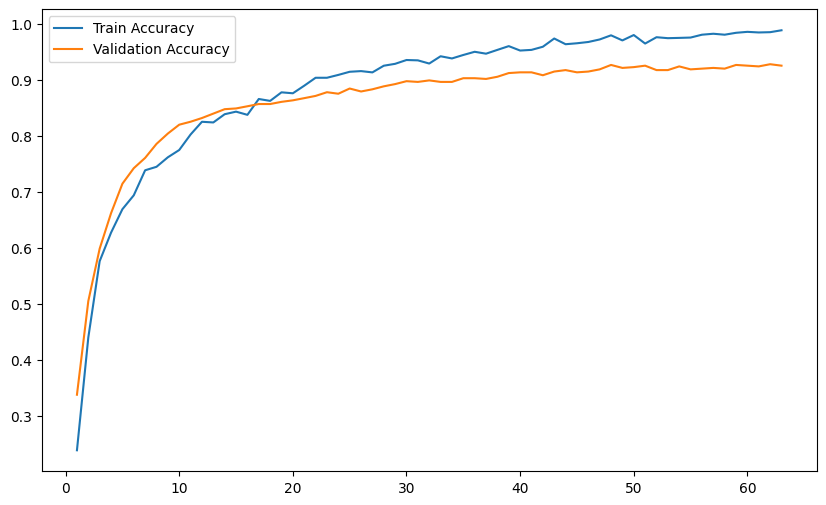

In [3]:
# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
# plt.title('MobileNetv2 Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
plt.legend()
# plt.grid(True)
plt.show()

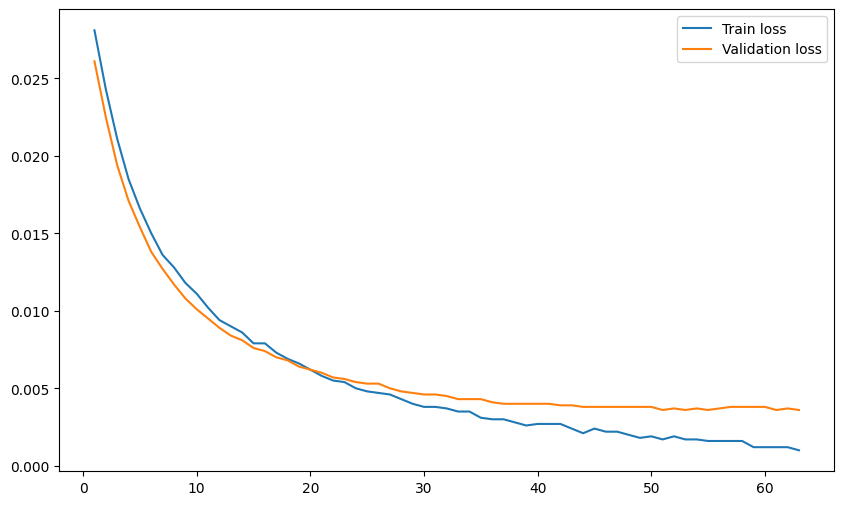

In [4]:
# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train loss')
plt.plot(epochs, val_loss, label='Validation loss')
# plt.title('MobileNetv2 Training and Validation losses')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
plt.legend()
# plt.grid(True)
plt.show()

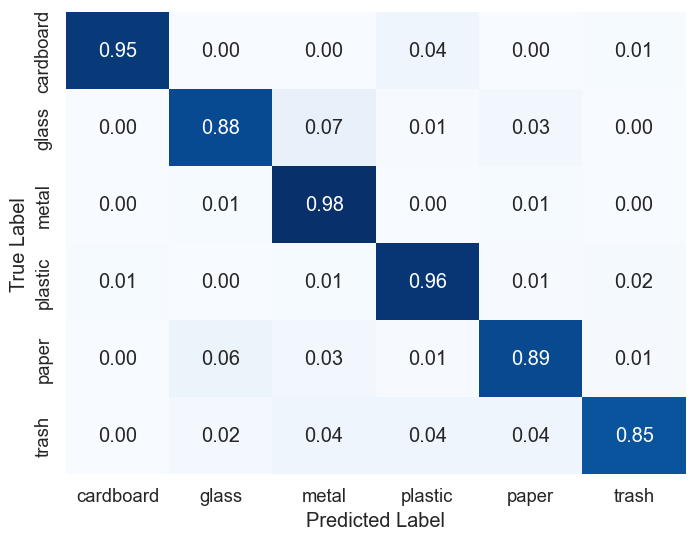

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Your confusion matrix
matrix = np.array([[110, 0, 0, 5, 0, 1],
                   [0, 130, 11, 1, 5, 0],
                   [0, 1, 122, 0, 1, 0],
                   [2, 0, 2, 183, 1, 3],
                   [0, 8, 4, 1, 120, 2],
                   [0, 1, 2, 2, 2, 39]])

# Calculate normalized confusion matrix
cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Define corrected class labels
classes = ['cardboard', 'glass', 'metal', 'plastic', 'paper', 'trash']

# Plot normalized confusion matrix with rotated class labels
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes[::], cbar=False)
# plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [6]:
total_sum = matrix.sum()
print("Total Sum for Normalization:", total_sum)

Total Sum for Normalization: 759
